In [ ]:
import numpy as np
import glob
import pandas as pd
import os
import matplotlib.pyplot as plt

In [ ]:
mode = 'remote'
dataset = 'librispeech'
batch_size = {"librispeech": 512, "imagenet": 512}[dataset]

In [ ]:
features = ["sim_compute_time", "threadpool_size", "block_size", 'io_time', 'processing_time', 'load_time', 'compute_time', 'completion_time', "memory", "throughput", 'num_batches']
def plot_rlt(dirs):
    data = []
    for dir in dirs:
        sim_compute_time = float(dir.split('/')[-1].split('-')[0].split('=')[1])
        
        num_batches = len(np.load(f"{dir}/data_load_time.npy"))
        load_time = np.mean(np.load(f"{dir}/data_load_time.npy"))
        compute_time = np.mean(np.load(f"{dir}/compute_time.npy"))
        completion_time = load_time + compute_time
        throughput = batch_size / completion_time

        memory_usage = np.load(f"{dir}/memory.npy", allow_pickle=True)
        memory = []
        for row in memory_usage:
            tmp = list(row.values())
            if len(tmp) < 2:
                continue
            tmp = [int(x) for x in tmp]
            memory.append(sum(tmp))
        memory = np.quantile(memory, 0.9, axis=0) / (1024 ** 2)
       
        try:
            block_size = int(dir.split('/')[-1].split('-')[1].split('=')[1])
        except:
            block_size = 1
        
        threadpool_size = 1
        if os.path.exists(f"{dir}/opt_config"):
            with open(f"{dir}/opt_config", 'r') as f:
                opt_config = f.readline().strip('\n').split(',')
                threadpool_size, block_size = opt_config
                threadpool_size, block_size = int(threadpool_size), int(block_size)
        
        io_time = np.mean(np.load(f"{dir}/io_time.npy")) / block_size
        processing_time = np.mean(np.load(f"{dir}/processing_time.npy"))
        processing_time -= io_time
        
        data.append([sim_compute_time, threadpool_size, block_size, io_time, processing_time, load_time, compute_time, completion_time, memory, throughput, num_batches])
    return data

# Exp1
Evaluate the dataset merging algorithm with our job and dataset placement algorithm:
- Scenario: 1-job/1-worker
- Datasets: ImageNet, LibriSpeech
- Baselines:
    - No merging: load individual files
    - Fixed Size Block: enumerate and benchmark multiple block sizes until meeting the early stop condition. (<= 5% imp for 3 block sizes) 
- Metrics:
    - Data loading time
    - Job completion time
    - Memory utilization

## Baseline 1: No merging

In [ ]:
baseline1 = pd.DataFrame()
for i in range(3):
    dirs = glob.glob(f"./experiments/exp1/baseline1/{dataset}/run{i+1}/{mode}/sim*")
    # dirs = glob.glob(f"./experiments/exp1/baseline1/sim*")
    data = plot_rlt(dirs)
    data = pd.DataFrame(data, columns=features)
    baseline1 = pd.concat([baseline1, data], axis=0)

std = baseline1.groupby('sim_compute_time').std()['throughput'].to_numpy()
baseline1 = baseline1.groupby('sim_compute_time').mean()
baseline1['throughput_std'] = std

baseline1.sort_values(by='sim_compute_time', inplace=True)
baseline1.reset_index(inplace=True)
baseline1

## Baseline 2: Fixed Block Size

In [ ]:
dirs = glob.glob(f"./experiments/exp1/baseline2/sim*")
data = plot_rlt(dirs)
data = pd.DataFrame(data, columns=features)
data.sort_values(by=['sim_compute_time', 'block_size'], inplace=True)

In [ ]:
baseline2 = pd.DataFrame()
for i in range(1):
    dirs = glob.glob(f"./experiments/exp1/baseline2/sim*")
    data = plot_rlt(dirs)
    data = pd.DataFrame(data, columns=features)
    data.sort_values(by=['sim_compute_time', 'block_size'], inplace=True)
    # rlt = pd.DataFrame()
    # for name, group in data.groupby(by="sim_compute_time"):
    #     group.sort_values(by="completion_time", inplace=True)
    #     group = group.iloc[0].to_frame().T
    #     rlt = pd.concat([rlt, group])
    # baseline2 = pd.concat([baseline2, rlt], axis=0)

data

## Ours

In [ ]:
# for f in glob.glob(f"./experiments/exp1/ours/{mode}/sim*/imagenet*.csv"):
#     df = pd.read_csv(f)
#     df['block_size'] = df['block_size'].astype(np.int32)
#     x = np.arange(df.shape[0])

#     plt.plot(x, df['batch_completion_time'], label=f.split('/')[-2])
#     # plt.xticks(x, df['block_size'], rotation=90)

# plt.legend()
# plt.xlabel("block_size(# samples)")
# plt.ylabel("batch completion time(s)")
# plt.grid()
# plt.show()

In [ ]:
ours = pd.DataFrame()
for i in range(3):
    dirs = glob.glob(f"./experiments/exp1/ours/{dataset}/run{i+1}/{mode}/sim*")
    # dirs = glob.glob(f"./experiments/exp1/ours/sim*")
    data = plot_rlt(dirs)
    data = pd.DataFrame(data, columns=features)
    data.sort_values(by=['sim_compute_time', 'block_size'], inplace=True)

    rlt = pd.DataFrame()
    for name, group in data.groupby(by="sim_compute_time"):
        group.sort_values(by="completion_time", inplace=True)
        group = group.iloc[0].to_frame().T
        rlt = pd.concat([rlt, group])
    ours = pd.concat([ours, rlt], axis=0)

std = ours.groupby('sim_compute_time').std()['throughput'].to_numpy()
ours = ours.groupby('sim_compute_time').mean()
ours['throughput_std'] = std
ours.sort_values(by='sim_compute_time', inplace=True)
ours.reset_index(inplace=True)
ours

In [ ]:
100 * (ours['throughput'] - baseline1['throughput']) / baseline1['throughput']

In [ ]:
x = np.arange(len(ours['sim_compute_time']))
plt.plot(x, ours['throughput'], label='Ours')
plt.errorbar(x, ours['throughput'], yerr = ours['throughput_std'], fmt ='*', capsize=3)
plt.plot(x, baseline1['throughput'], label='No-merging')
plt.errorbar(x, baseline1['throughput'], yerr = baseline1['throughput_std'], fmt ='*', capsize=3)

plt.xlabel = 'Simulated GPU Computation Time (s) / Batch'
plt.ylabel = 'Throughput (samples/s)'
plt.xticks(x, ours['sim_compute_time'])
plt.grid()
plt.legend()
plt.show()

In [ ]:
# ours.to_csv('./experiments/exp1/ours-librispeech-remote.csv', index=None)
# baseline1.to_csv('./experiments/exp1/baseline-librispeech-remote.csv', index=None)

In [49]:
traces = glob.glob(f"./experiments/exp1/ours/librispeech/run3/remote/sim*/deepspeech*")
traces.sort(key=lambda x: float(x.split('/')[-2].split('=')[1]))
traces_data = []
compute_times = []
for trace in traces:
    compute_times.append(trace.split('/')[-2].split('=')[1])
    df = pd.read_csv(trace)
    traces_data.append(df)
# traces_data

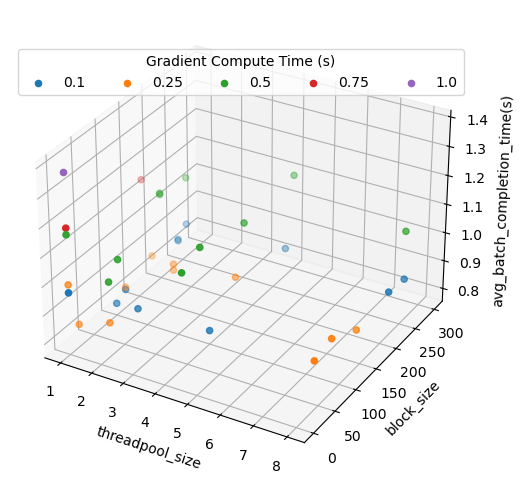

In [52]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 创建一个新的3D图像
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

for i, df in enumerate(traces_data):
    # 使用 scatter 方法创建3D散点图
    ax.scatter(df['threadpool_size'], df['block_size'], df['batch_completion_time'], label=compute_times[i])

ax.set_xlabel('threadpool_size')
ax.set_ylabel('block_size')
ax.set_zlabel('avg_batch_completion_time(s)')

legend_title = "Gradient Compute Time (s)"
plt.legend(title=legend_title, bbox_to_anchor=(0.5, 0.8), ncol=5, loc="lower center")

plt.show()